# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project 2: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: ** To answer which kind of supervised learning problem this is, we must check what kind of variable we are trying to predict. In this case, the goal is to predict whether or not students need early intervention because they may fail to graduate. This sounds like a boolean variable. We try to divide students into two distinct categories, those who need intervention and those who don't. Therefore, this is a classification problem.

The answer would be different if we were to predict a real-valued score supposed to indicate how much a student needs intervention. In this case, we would have a regression problem. However, I assume a boolean target variable and say classification.

_Side note for the interested project reviewer_: As we see below, the target variable we predict is whether or not students will fail to graduate, not whether they need intervention. Thus, implicitly, we assume a student failing to graduate is equivalent to a student needing intervention. That is, there exist no students who will fail but need no intervention, say because an intervention would be pointless since since its chance of success is marginal for this subgroup of students. Imho: A very positive idea of man embodied in this project. I like that :)

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score

# Read student data
student_data = pd.read_csv("student-data.csv")
print("Student data read successfully!")

Student data read successfully!


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [2]:
# TODO: Calculate number of students
n_students = len(student_data)

# TODO: Calculate number of features
n_features = len(student_data.columns) - 1 # 30 feature columns, one target column

# TODO: Calculate passing students
n_passed = len(student_data[student_data['passed'] == 'yes'])

# TODO: Calculate failing students
n_failed = n_students - n_passed

# TODO: Calculate graduation rate
grad_rate = float(n_passed) / float(n_students) * 100

# Print the results
print("Total number of students: {}".format(n_students))
print("Number of features: {}".format(n_features))
print("Number of students who passed: {}".format(n_passed))
print("Number of students who failed: {}".format(n_failed))
print("Graduation rate of the class: {:.2f}%".format(grad_rate))

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [3]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print("Feature columns:\n{}".format(feature_cols))
print("\nTarget column: {}".format(target_col))

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print("\nFeature values:")
print(X_all.head())

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [4]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print("Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns)))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [5]:
# TODO: Import any additional functionality you may need here
from sklearn.cross_validation import train_test_split

# TODO: Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# TODO: Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test= train_test_split(X_all, y_all, train_size=num_train, random_state=42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 300 samples.
Testing set has 95 samples.


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: **

- **Logistic regression (LR): the simple and fast linear baseline model.**
    - _Application in practice_: One application area I know is credit scoring. The goal would be to use information about a debtors to assess the probability that they default on a credit. Typical credit scoring software like Statistica [mentions logistic regression](http://www.statsoft.com/Textbook/Credit-Scoring) discusses LR as the default method. A [text book](https://www.amazon.de/Credit-Scoring-Risk-Managers-Elizabeth/dp/1450578969) written for practicioners in the field focuses solemnly on LR and does not even mention any alternatives.
    - _Strength_: LR is a simple model that can be trained efficiently. Sklearn's implementation uses coordinate descent for LR ([sklarn docs](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)), which scales linearly with the size of the dataset ([Minka 2003](http://research.microsoft.com/en-us/um/people/minka/papers/logreg/minka-logreg.pdf)). It also has only a single hyperparameter to tune regularization (L1 or L2). Thus, you can quickly do extensive grid search and cross validation, even for larger datasets. Moreover, [LR returns well-calibrated probabilities](http://scikit-learn.org/stable/modules/calibration.html) rather than 'just' an estimate of the most probable answer (i.e., it quantifies confidence in the prediction). It is also available in lots of software packages (or, alternatively, easy to implement) and very efficient during prediction. Thus, it is easy to integrate into production environments. A nice property of sklearn's LR implementation is that it [supports class_weights](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), which allows to account for imbalanced class distributions.
    - _Weaknesses_: LR is a linear model and cannot capture any complex relationships between the data and the target variable. It is a high bias model and given sufficient data, other more complex models with less bias may outperform it.
    - _Why I choose it_: LR is easy to apply and a solid baseline to compare other more complex methods to. It is widely used in many industries (e.g., called the "[standard industry workhorse](https://mahout.apache.org/users/classification/logistic-regression.html)" in the Mahout docs). Thus, it should be the first thing to start with when looking for an optimal classifier since a more complex model should at least beat LR. Of my three methods, it is the one with high bias and low variance.

- **Support Vector Machine (SVM): the more complex non-linear contender** --- I assume we are talking about non-linear SVMs here (RBF-kernel and the like). Purely linear SVMs often perform about as good as logistic regression in my personal experience and also according to [Andrej Karpathy's lecture](http://cs231n.github.io/linear-classify/#svm-vs-softmax) on computer vision. I do not expect any significant difference to the logistic regression classifier for a linear kernel.
    - _Application in practice_: One example for SVMs used in practice is predicting customer churn in the automotive sector, as described in this [KDnuggets case study](http://www.kdnuggets.com/2014/09/automotive-customer-churn-prediction-svm-som.html). [Wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine#Applications) states SVMs are frequently used for text and image classification, although I guess deep neural networks are taking over these days.
    - _Strenghts_: The big advantange of SVMs are that they apply the kernel trick to create non-linear decision boundaries. Thus, SVMs can capture very complex non-linear interactions in the data. Like Lr, sklearn's SVM implementation [supports class_weights](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), which allows to account for imbalanced class distributions. 
    - _Weaknesses_: SVMs are problematic if you have many data points and also many features. In the [sklearn documentation](http://scikit-learn.org/stable/modules/svm.html#complexity), it says the quadratic to cubic in the number of samples due to solving a quadratic program, which is prohibitive for large datasets. The sklearn implementaiton is based on the LIBSVM package. Consistent with what the sklearn documentation says, the [user guide of LIBSVM](https://www.cs.sfu.ca/people/Faculty/teaching/726/spring11/svmguide.pdf) specifically discourages applying (nonlinear) SVMs in this case due to computational inefficiency and recommends using LIBLINEAR, i.e., a linear method, instead. SVMs also have many hyperparameter options. You must specify C (for regularization) and kernel/gamma (for non-linear magic). Multiple options for kernels are [provided by sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) but you could invent and implement your own (see [this book chapter](http://www.gaussianprocess.org/gpml/chapters/RW4.pdf) for a glimpse into the extensive science of kernels). Thus, finding good hyperparameters can be hard work and possibly very time-consuming. Another weakness is that SVMs can only do binary classification. For multi-class classification, you must resort to more complex [one-to-one schemes](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) which fit classifiers for each pair of classes.
    - _Why I choose it_: Trying an SVM on the given dataset after doing LR seems like a good choice since SVMs can capture non-linear interactions. Comparing the two models given an indication as to whether non-linear classifiers are needed or not. Moreover, the classes in the given dataset are slightly imbalanced (67% vs 33%), so the class_weight paramteter may be helpful here. The dataset is also relatively small (only a few 100 rows), which is why the performance limitations of SVMs should not be too bad. Since we have a binary classification problem, SVM's limitation to binary classification is not a problem either. GBM is the medium bias and medium variance model of my three models.

- **GradientBoostingClassifier (GBC): the computationally intensive ensemble method**
    - _Application in practice_: Boosting is extremely popular in many Kaggle competitions. For instance, Anthony Goldbloom (Kaggle CEO) recently said boosting is _"winning practically every competition in the structured data category"_ [KDnuggest interview](http://www.kdnuggets.com/2016/01/anthony-goldbloom-secret-winning-kaggle-competitions.html). One of the many examples in which gradient boosting performed very well was predicting the relevance of product search results (see [kaggle blog](http://blog.kaggle.com/2016/06/15/home-depot-product-search-relevance-winners-interview-2nd-place-thomas-sean-qingchen-nima/) for a detailed description).
    - _Strenghts_: As an ensemble method, GBC is a very robust classifier that can be applied easily with little preprocessing. It can capture very complex non-linear depenencies in the data. You can increase the number of boosting iterations of GBC as much as you want without danger of overfitting. Instead, it tends to improve classification performance more and more the longer you run it. Thus, you can use GBC to really get the most out of your data. Like SVMs, GBC also has a parameter sample_weight that allows to account for imbalanced class distributions. 
    - _Weaknesses_: The clear drawback of boosting is that it trains lots of weak learners and due to the sequentiality of boosting, you cannot train these weak learners in parallel. Each tree individually requires time O(n * log(n)) for training (this is the [optimized implementation of sklearn](http://scikit-learn.org/stable/modules/tree.html#complexity), normally it is O(n^2 log(n) for trees). Thus, gradient boosting will take considerable time if you run it many times, which is necesary to benefit from ensembling. You must also carefully select the many hyperparameters (too many to list them here, check out [sklarn's docs](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)), which adds to the computational cost of boosting. In particular, you must get regularization right since if your individual weak learners overfit to the training data, then boosting will not improve the performance no matter how long you run it (this is well explained in the Udacity's lectures on boosting). Another consideration could be deployment to production environments, which will be a lot more complicated as compared to simple models like LR (you would have to deploy all trained weak learners as well as the ensembling logic).
    - _Why I choose it_: GBC will allow to go to the limits of whats possible with the given dataset. Whatever complex relationships exist in the problem, GBM has a chance to find them provided that the amount of data is sufficient. Again, since the dataset is rather small, extensive experiments with hyperparameters are feasible. Having the ability to also adjust sample weights means I do not have to undersample (other techniques like [SMOTE](https://www.jair.org/media/953/live-953-2037-jair.pdf) exist to mitigate imbalanced class distributions, but I don't think they will be necessary here). GBM is the low bias and high variance model I choose.
    
   

### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [6]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print("Made predictions in {:.4f} seconds.".format(end - start))
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print("F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train)))
    print("F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test)))

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [7]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

my_random_state=42

# TODO: Initialize the three models
clf_A = LogisticRegression(random_state=my_random_state)
clf_B = SVC(random_state=my_random_state)
clf_C = GradientBoostingClassifier(random_state=my_random_state)
classifiers = [clf_A, clf_B, clf_C]

# TODO: Set up the training set sizes
X_train_100 = X_train[:100]
y_train_100 = y_train[:100]

X_train_200 = X_train[:200]
y_train_200 = y_train[:200]

X_train_300 = X_train[:300]
y_train_300 = y_train[:300]

train_sets = [(X_train_100, y_train_100), (X_train_200, y_train_200), (X_train_300, y_train_300)]

# TODO: Execute the 'train_predict' function for each classifier and each training set size
# train_predict(clf, X_train, y_train, X_test, y_test)
for clf in classifiers:
    for X, y in train_sets:
        train_predict(clf, X, y, X_test, y_test)

Training a LogisticRegression using a training set size of 100. . .
Trained model in 0.0025 seconds
Made predictions in 0.0004 seconds.
F1 score for training set: 0.8593.
Made predictions in 0.0003 seconds.
F1 score for test set: 0.7647.
Training a LogisticRegression using a training set size of 200. . .
Trained model in 0.0028 seconds
Made predictions in 0.0003 seconds.
F1 score for training set: 0.8562.
Made predictions in 0.0003 seconds.
F1 score for test set: 0.7914.
Training a LogisticRegression using a training set size of 300. . .
Trained model in 0.0044 seconds
Made predictions in 0.0005 seconds.
F1 score for training set: 0.8468.
Made predictions in 0.0003 seconds.
F1 score for test set: 0.8060.
Training a SVC using a training set size of 100. . .
Trained model in 0.0023 seconds
Made predictions in 0.0011 seconds.
F1 score for training set: 0.8777.
Made predictions in 0.0013 seconds.
F1 score for test set: 0.7746.
Training a SVC using a training set size of 200. . .
Trained mo

### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** Classifer 1 - Logistic Regression**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |        0.0025           |      0.0004            |      0.8593      |    0.7647       |
| 200               |        0.0028           |      0.0003            |      0.8562      |    0.7914       |
| 300               |        0.0044           |      0.0005            |      0.8468      |    0.8060       |

** Classifer 2 - Support Vector Machine**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |         0.0023          |       0.0014           |     0.8777       |     0.7746      |
| 200               |         0.0119          |       0.0020           |     0.8679       |     0.7815      |
| 300               |         0.0084          |       0.0016           |     0.8761       |     0.7838      |

** Classifer 3 - Gradient Boosting Classifier**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |         0.0519          |        0.0005          |      1.0000      |     0.7519      |
| 200               |         0.0725          |        0.0008          |      0.9964      |     0.7591      |
| 300               |         0.1052          |        0.0011          |      0.9739      |     0.7794      |

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: ** Dear board of supervisors,

I recommend you go for the Logistic Regression classifier. My preliminary experiments confirm that it is in fact the fastest of all three models (in terms of both training and prediction time). When using it, you will save valuable milliseconds of CPU time which you can spend on higher value computations.

Moreover, Logistic Regression also seems to be the most effective of all tested models. The f1 score on the test set is higest, suggesting that it will perform best on future students. Moreover, the spread between F1 scores on train and test set are lowest. This is an indicator that LR is not overfitting to the small training set as much as the other models do.

In [8]:
##################### Helper function for next task #########################
# --- I now define a function that plots the Logistic Regression decision boundary for a 2D problem ---
# --- The plot will be visual aid for the next task ---
###############################################################################

from sklearn.grid_search import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
%matplotlib inline

def plot_2d_decision_surface():
    # train with lasso for feature selection
    parameters = [
      {'C': np.logspace(-2, 4, num=10)}
     ]
    grid_lasso = GridSearchCV(LogisticRegression(penalty='l1', random_state=42), parameters, scoring=make_scorer(f1_score, pos_label='yes'), cv=5, verbose=0)
    grid_lasso.fit(X_train, y_train)
    sfm = SelectFromModel(grid_lasso.best_estimator_, threshold=0.10, prefit=True)

    # get the two most important features
    n_features = sfm.transform(X).shape[1]
    while n_features > 2:
        sfm.threshold += 0.1
        X_transform = sfm.transform(X)
        n_features = X_transform.shape[1]
    
    # train L2 model on the two features
    lr_predictor = LogisticRegression(C=1e5)
    lr_predictor.fit(X_transform, y_train)
    
    # prepare meshgrid
    h = .02
    x_min, x_max = X_transform[:, 0].min() - .5, X_transform[:, 0].max() + .5
    y_min, y_max = X_transform[:, 1].min() - .5, X_transform[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = lr_predictor.predict(np.c_[xx.ravel(), yy.ravel()])
    Z[Z=='yes'] = 1
    Z[Z=='no'] = 0
    Z = Z.reshape(xx.shape)
    
    # scatterplot of data + decision boundary
    plt.figure(figsize=(7, 7))
    plt.title("Prediction with two most important features")
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
    feature1 = X_transform[:, 0] + np.random.randn(len(X_transform[:, 0])) / 10.0 # add small noise for visualization since data is actually categorical
    feature2 = X_transform[:, 1] + np.random.randn(len(X_transform[:, 1])) / 10.0 # add small noise for visualization since data is actually categorical
    colors = y_train.copy()
    colors[colors=='yes'] = 1.00
    colors[colors=='no'] = 0.00
    plt.scatter(feature1, feature2, c=colors.values, alpha=0.6, cmap=plt.cm.Paired)
    plt.xlabel(X_train.columns[sfm.get_support()][0])
    plt.ylabel(X_train.columns[sfm.get_support()][1])
    plt.xlim([np.min(feature1) - 0.5, np.max(feature1) + 0.5])
    plt.ylim([np.min(feature2) - 0.5, np.max(feature2) + 0.5])
    plt.show()

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: **

The model I have created for you is able to predict how likely a student is to graduate. It does so by analysing the 395 that already went through the program. By looking at the attributes of these students, it identifies cues that have been idicative for failing to graduate in the past. We can look for these cues in future students to get our intervention system. To get a feeling for how the model works, consider the picture below. Image you record two attributes for your students:
- _goout_: how much they go out with friends (the higher the value, the more they tend to go out)
- _failures_: how often they failed to pass a class before (the higher the value, the more often they failed before)

You would probably expect both numbers to drive the chance of failing to graduate. You could then verify this expectation by drawing a picture like the one below. For each student, you would draw a blue dot if he failed to graduate and a red dot if he did not. You would draw dots more to the right the higher the _failures_ attribute value is and the more to the top the higher the _goout_ attribute value is. If your expectation is correct, you would see more blue dots (= studentes failed to graduate) in the upper right corner of your picture. Looking at the picture, you indeed see more blue dots than red ones there. You could now draw a line through the picture to seperate two areas, one in which mostly blue dots are and another in which more red than blue dots are. In the picture, you can see an example of such a line. You now have two areas, one in which students are likely to fail to graduate and the other in which they are likely to pass. Drawing a line is what the model I've created for you does when it learns from data.

If you see a new student now, then you can draw a new dot into the picture according to his _failure_ and _goout_ values and see where it the dot is.  You would now check in which of the two areas the student is. Depending on that, you would either estimate he is likely to fail to graduate or not. The closer the dot is to the line, the less confident you will be about the prediction, i.e., you will assign higher probabilities to points far away from the line. To see why, check the dots in the picture. Close to the line, you have many blue and red dots on either side, so you cannot be sure. Deep inside the blue-shaded area though, most dots are blue. Similarly, deep inside the yellow-shaded area, most dots are red (exceptions exist of course). Checking on which side of the line a point is and how far it is away is what the model I've created for you does when it predicts the chance that a student fails to graduate.

The reason you need the model and not just a picture is that the model does above described things mathematically and not in pictures, which is why it can look at more than just two attributes. If we were to look at, say, five attributes, we could not draw a picture anymore. The model however can perfectly work with the five attributes. 

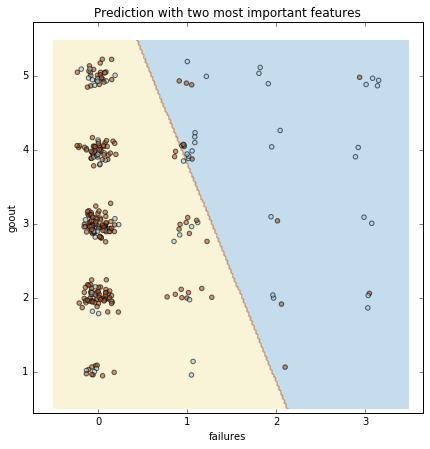

In [9]:
plot_2d_decision_surface()

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.gridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [10]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
import numpy as np

# TODO: Create the parameters list you wish to tune
parameters = [
  {'C': np.logspace(-4, 10, num=100),
   'class_weight': ['balanced', None]}
 ]

# TODO: Initialize the classifier
clf = LogisticRegression(random_state=42)

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label='yes')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=f1_scorer, cv=5, verbose=0)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

print("Best score on hold-out data during grid search: {:.4f}".format(grid_obj.best_score_))

# Report the final F1 score for training and testing after parameter tuning
print("Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train)))
print("Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test)))

Best score on hold-out data during grid search: 0.8210
Made predictions in 0.0005 seconds.
Tuned model has a training F1 score of 0.8358.
Made predictions in 0.0002 seconds.
Tuned model has a testing F1 score of 0.7778.


### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: ** The final F1 score on the training data is 0.8358. Sadly, the final F1 on the test data is only 0.7778, which is much less than I hoped it would be. In particular, the F1 score on the test data during my preliminary experiments above was 0.8060. It seems as if the preliminary results gave me a good result only by chance. 

In addition to the scores defined by Udacity, I've also printed out the best score during grid search in the cell above. It was 0.8210. Thus, CV search seems to work well. There are mutiple explanations for this drop in performance on the test set:
- test set too small: like all quantities we work with, the F1 score on the test set is just an estimate of future performance. With only 95 data points, it is rather small. Hence, the variance of the score is probably quite high, which is why we should not trust the score too much. As a remedy, we could cross-validate over the entire pipeline to estimate the variance and to improve the estimate. What I mean with this is that we do not just cross-validate the validation error for hyperparameter selection but also cross-validate the test error. This would of course increase the computational complexity by a factor of, say, 5 for 5-fold CV.
- overfitting to validation set: While we cross-validate the validation set, there is still a danger to overfit our hyperparameters to it. In the code above, we try many different hyperparameter configurations and choose those which give us best validation performance. Therefore, we should expect our true performance on new data to be lower than what the cross-validation score of the best hyperparameter setting tells us.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.